# Backporting "yield from" to Python 2.7 

__Or, How I Learned to Stop Worrying and Love the Generator__

_a.k.a. "AST Manipulation for Fun and Profit"_

I know your initial reaction. 

"2.7 is dead, get over it." 

"Python 3 was released _ten years ago_." 

"Clinging to the past like this is only _hurting_ the community!"

However, if you'll grant me the benefit of the doubt, I can promise you that this post will only incidentally be about Python 2.7, and (instead) mostly be about techniques and concepts that are equally well (better, even!) applied to Python 3.6, 3.7, and beyond.

## Motivation

That being said, it is a _little_ about Python 2.7, so let's first motivate why we'd want to backport this feature. After all, a lot of people have no choice but to work on legacy 2.7 codebases, and never find themselves _needing_ (per se) a lot of what has been introduced in Python 3 - nice though it may be. What makes `yield from` special?

### A bit about generators
To start, it'd be helpful to know what `yield from` does. As you'll probably know already, generators are defined much like functions, but with a `yield` keyword that dictates what they will, well, _yield_. For instance:

In [1]:
def routes(starting_places, you_wanna_go=True, get_away_from_it_all=True):
    destinations = ['aruba', 'jamaica', 'bermuda', 'bahama']
    for starting_place in starting_places:
        for destination in destinations:
            if starting_place != destination:
                yield (starting_place, destination)
        if you_wanna_go and get_away_from_it_all:
            yield (starting_place, 'kokomo')

With our `routes` generator above, we can supply an iterable of starting places and get back all possible routes.

In [2]:
list(routes(starting_places=['cleveland']))

[('cleveland', 'aruba'),
 ('cleveland', 'jamaica'),
 ('cleveland', 'bermuda'),
 ('cleveland', 'bahama'),
 ('cleveland', 'kokomo')]

However, the best part (and a big differentiator from using e.g. a `for` loop or list comprehension) is that each of these values is not yielded by `routes` until we ask for it, meaning that we only perform the bare minimum computation. We can illustrate this by asking for our routes one at a time:

In [3]:
g = routes(['lawrence, kansas'], get_away_from_it_all=False)
print("We're dealing with a {!r}".format(type(g)))
print(next(g))
print(next(g))
print("Ooo, I wanna take ya")
print(next(g))
print(next(g))
print("That should be the last of them, but let's give it one more shot.")
print(next(g))

We're dealing with a <type 'generator'>
('lawrence, kansas', 'aruba')
('lawrence, kansas', 'jamaica')
Ooo, I wanna take ya
('lawrence, kansas', 'bermuda')
('lawrence, kansas', 'bahama')
That should be the last of them, but let's give it one more shot.


StopIteration: 

What we've seen above, the pattern of repeatedly calling `next` on the generator until a `StopIteration` exception is raised, is actually a normal part of Python's iterator protocol - this is how, e.g., a `for` loop or comprehension knows when it's exhausted its target:

In [4]:
def numbers():
    yield -1 + 2
    yield 1 + 1
    raise StopIteration("This should make a big mess if we don't expect it!")
    yield 9 / 3  # we never end up performing this division
    yield 1 / 0  # or this one!
    
[number for number in numbers()]

[1, 2]

All in all, the "[lazy](https://en.wikipedia.org/wiki/Lazy_evaluation)" behavior of generators lets us do pretty interesting things, like representing infinite series without _computing_ infinite series, something that Haskell tutorials are weirdly insistent on bragging about:

In [5]:
def ellipses():
    state = '...'
    while True:
        yield state
        state += ' ...'
        
for ellipsis in ellipses():
    print(ellipsis)
    if len(ellipsis) >= 10:
        print("Ah, it's getting late, I should go...")
        break

...
... ...
... ... ...
Ah, it's getting late, I should go...


_Take_ that, _type safety!_

### Yield from - what's the big whoop?

So, then, if we know what `yield` does, what does `yield from` do? Well, it's more-or-less exactly what it says on the tin - it "`yield`s `from`" another generator! That is to say, `yield from` allows us to nest generators nicely. For instance:

In [6]:
def odd_numbers(max_number):
    n = 1
    while True:
        yield n
        n += 2
        if n > max_number:
            break

In [7]:
def good_ol_generator(differnt_generator):
    yield "startin'"
    yield from differnt_generator
    yield "that'n's finished, I reckon"
    
for item in good_ol_generator(odd_numbers(4)):
    print(item)

SyntaxError: invalid syntax (<ipython-input-7-7fefa543b1b7>, line 3)

... would, if `yield from` were syntactically valid in Python 2.7, give us:
```
startin'
1
3
that'n's finished, I reckon
```
... To which you might respond, "That's all this is about? I can't believed I've been duped into reading this far."

But, if you were just a bit more game (but similarly dismissive), you might equally respond, "So what - can't you just do that with the following?"

In [8]:
def good_ol_generator(differnt_generator):
    yield "startin'"
    for item in differnt_generator:
        yield item
    yield "that'n's finished, I reckon"
    
for item in good_ol_generator(odd_numbers(4)):
    print(item)

startin'
1
3
that'n's finished, I reckon


The answer is: in a sense, yes, as you can clearly see above - but in a much deeper sense, no, not at all! To understand the nuance here, we'll need to know a bit more about generators.

### Generating is a two-way street

Let's take a step back. Remember when I said that generators only compute values when we ask for them? What exactly does that mean? Well, take (for example) the following generator:

In [9]:
import time

def mysterious_codes():
    time.sleep(1)  # wait for the ideal opportunity...
    yield "The rooster has left the henhouse."
    for number in range(100):
        number * 2 - 1  # try to look inconspicuously busy...
    yield "The farmer is in the dell!"
    print("Last transmission, I've been compromised!")

What gets executed, and when, when we run the following?

In [10]:
# Point A
agent_message = mysterious_codes()
# Point B
print("Message 1: {}".format(next(agent_message)))
# Point C
print("Message 2: {}".format(next(agent_message)))
# Point D
print("Message 3: {}".format(next(agent_message)))
# Point E

Message 1: The rooster has left the henhouse.
Message 2: The farmer is in the dell!
Last transmission, I've been compromised!


StopIteration: 

If we color-coded it (roughly), with <span style="color: white; background-color: #B03A2E">red</span> being code run between points `A` and `B`, <span style="color: white; background-color: #8E44AD">purple</span> being code run between `B` and `C`, <span style="color: white; background-color: #229954">green</span> between `C` and `D`, and <span style="color: white; background-color: #2874A6">blue</span> between `D` and `E`, it would look something like:

<span style="font-family: Consolas, monospace; color: white">
<span style="background-color: #8E44AD">
time.sleep(1)&nbsp;&nbsp;# wait for the ideal opportunity...<br />
yield "The rooster has left the henhouse."<br />
</span>
<span style="background-color: #229954">
for number in range(100):<br />
&nbsp;&nbsp;&nbsp;&nbsp;number * 2 - 1&nbsp;&nbsp;# try to look inconspicuously busy...<br />
yield "The farmer is in the dell!"<br />
</span>
<span style="background-color: #2874A6">
print("Last transmission, I've been compromised!")<br />
</span>
</span>

That is to say: when a generator is first instantiated (`agent_message = mysterious_codes()`), nothing is executed. Thereafter, each time `next` is called, the generator executes code until it reaches the next `yield` - then returns control back to the caller, returning as a value whatever followed `yield`. This continues (so long as `next` keeps getting called) until the generator either raises `StopIteration`, reaches a `return`, or reaches the end of the generator's definition (really, under the hood, an implicit `return`).

From the perspective of the parent frame, the call to `next` is an indication to hand back control to the generator - i.e., in the code below, `next(agent_message)` is executed _before_ the purple block above, and the rest _afterward_ (after being returned the `yield`ed message).

<span style="font-family: Consolas, monospace; color: white">
<span style="background-color: #8E44AD">print("Message 1: {}".format(<span style="background-color: #B03A2E">next(agent_message)</span>))

This, fundamentally, is really no different from, for example, calling a function during an assignment, e.g.:

`result = calculate(x, y)`

, in that the parent frame is yielding control to the `calculate` function and waiting for whatever it `return`s, before being able to assign that to `result`. 

What this all means is that _generators are a fundamental control flow mechanism in Python_. Whoever chose `yield` as the name of the generator keyword was a _genius_; "yield" in English can be used in one of two ways: a recipe can "yield" a dozen cookies, or a refining process can "yield" iron ingots from ore, but a car can also "yield" way to another car, or a ruler can "yield" their command to someone else. "Yield" signifies both production of some item or items via some process, as well as deference or delegation of control to something else - and Python's `yield` captures both these meanings _precisely_*.

\* _Although the second meaning didn't apply when the keyword was first introduced, so take what you will from this - either magnificent foresight, or an auspicious decision in hindsight._

To illustrate: supposing we wanted to scrape all the links from some page. Let's say, however, that if the time to load the initial page was too slow, we'd rather just give up. One way of modeling this is:

In [11]:
import requests
from lxml import etree

def scrape_links(url):
    result = requests.get(url)
    link_urls = etree.HTML(result.content).xpath("//a/@href")
    if result.elapsed.total_seconds() > 0.25:
        return
    for link_url in link_urls:
        yield requests.get(link_url)
        
def scrape_and_process(urls):
    for url in urls:
        scraped_pages = list(scrape_links(url))
        process(scraped_pages)

However, what if we need the go/no-go logic to be more complex? Maybe rely on some context, such as how much time we've already spent scraping other sites, and how much time we have allotted total for this?

In [12]:
def scrape_links(url, spent_time, allotted_time):
    result = requests.get(url)
    link_urls = etree.HTML(result.content).xpath("//a/@href")
    remaining_time = allotted_time - (spent_time + result.elapsed.total_seconds())
    if result.elapsed.total_seconds() * len(link_urls) > remaining_time:
        return
    for link_url in link_urls:
        yield requests.get(link_url)
        
def scrape_and_process(urls):
    max_time = 10  # seconds
    start_time = time.time()
    for url in urls:
        scraped_pages = list(scrape_links(
            url,
            spent_time=time.time() - start_time,
            allotted_time=max_time
        ))
        process(scraped_pages)

But now, increasingly, our `scrape_links` function is looking less like it's about scraping links and more like it's about managing time - pretty unclean, with muddled responsibilities. 

If generators _weren't_ lazy, we'd probably have to solve this by doing something like the following:

In [13]:
def scrape_links_part_1(url):
    result = requests.get(url)
    state = etree.HTML(result.content)
    return result.elapsed.total_seconds(), state

def scrape_links_part_2(previous_state):
    link_urls = previous_state.xpath("//a/@href")
    for link_url in link_urls:
        yield requests.get(link_url)
        
def scrape_and_process(urls):
    max_time = 10  # seconds
    start_time = time.time()
    for url in urls:
        initial_request_time, scrape_links_state = scrape_links_part_1(url)
        if not ok_to_proceed(start_time, max_time, initial_request_time):
            continue
        scraped_pages = list(scrape_links_part_2(scrape_links_state))
        process(scraped_pages)

Of course, the problem _now_ is that `scrape_and_process` for some reason is left having to temporarily hold onto the `scrape_links_state` from `scrape_links_part_1` - which _it_ doesn't necessarily care about.

Thankfully, we can instead do this:

In [14]:
def scrape_links(url):
    result = requests.get(url)
    state = etree.HTML(result.content)
    yield result.elapsed.total_seconds()
    link_urls = state.xpath("//a/@href")
    for link_url in link_urls:
        yield requests.get(link_url)
        
def scrape_and_process(urls):
    max_time = 10  # seconds
    start_time = time.time()
    for url in urls:
        g = scrape_links(url)
        initial_request_time = next(g)  # our first yielded value
        if not ok_to_proceed(start_time, max_time, initial_request_time):
            continue
        scraped_pages = list(g)  # all subsequent yielded values
        process(scraped_pages)

This way, `g` keeps its state entirely internal to itself - but also doesn't make any further requests without the go-ahead of `scrape_and_process`, the decision of which can be arbitrarily complex and _completely opaque_ to `scrape_links`*.

\* _One caveat - yes, this `does` mean that `result` and `state` persist in memory as long as we hold a reference to `g` from anywhere else in the code - since Python never knows whether we're going to resume its computation or not!_

But now, here's the kicker: suppose we want `scape_links` to sometimes only request _some_ of the page's links - _as dictated by_ `scrape_and_process`. Are we going to be forced to go back to our two-part, two-function solution, and have the number of pages to scrape be passed in along with `previous_state`? Of course, we could just have `scrape_and_process` only call `next(g)` that many times - but supposing that we'd maybe want `scrape_links` to prioritize some links over others, based not only on the links themselves, but the number of pages to scrape? Maybe `.php` pages take 5 times longer on average than `.html` to request, but are much more valuable - but, if we're only going to be allowed to scrape a single page, that means the `.php` probably doesn't have time to load at all, and so we'd better try a `.html`? Are we just doomed?

No! 

The trick is that there's another way entirely to prompt generators to resume calculation - a way that _also_ lets you send values _to_ the generator, enabling _two-way communication_. That way is the `.send` method. Here's a very simple example:

In [15]:
def sendable(initial_value):
    print("Generator:\tInitial value was `{}`".format(initial_value))
    sent_value = yield initial_value * 2
    print("Generator:\tI got sent `{}`!".format(sent_value))
    sent_value = yield sent_value * 2
    print("Generator:\tI got sent `{}` - but now I'm done.".format(sent_value))

g = sendable(initial_value='hello')
first_yielded_value = next(g)
if 'hello' in first_yielded_value:
    second_yielded_value = g.send('world')
    print("Calling frame:\tThe second thing on this side was `{}` - first was `{}`".format(
        second_yielded_value,
        first_yielded_value
    ))
    g.send('goodbye')

Generator:	Initial value was `hello`
Generator:	I got sent `world`!
Calling frame:	The second thing on this side was `worldworld` - first was `hellohello`
Generator:	I got sent `goodbye` - but now I'm done.


StopIteration: 

As it transpires, `next(g)` is also actually equivalent to `g.send(None)` - and the [Python generator protocol](https://www.python.org/dev/peps/pep-0342/#new-generator-method-send-value), in fact, _requires_ that the first value sent to a newly initialized generator be `None`.

With this now in mind, we can create exactly the version of `scrape_links` that we were hoping for:

In [16]:
def scrape_links(url):
    result = requests.get(url)
    state = etree.HTML(result.content)
    num_allowed_requests = yield result.elapsed.total_seconds()
    link_urls = state.xpath("//a/@href")
    for link_url in prioritized(link_urls, num_allowed_requests):
        yield requests.get(link_url)
        
def scrape_and_process(urls):
    max_time = 10  # seconds
    start_time = time.time()
    for url in urls:
        g = scrape_links(url)
        initial_request_time = next(g)
        allowed_requests = calc_allowed_requests(start_time, max_time, initial_request_time)
        if not allowed_requests:
            continue
        first_scraped_page = g.send(allowed_requests)
        scraped_pages = list(g)
        scraped_pages.append(first_scraped_page)
        process(scraped_pages)

If we imagine that only one URL was allowed to be scraped, the periods of execution within `scrape_links` would look like the following (I've added the otherwise implicit `return` for illustrative purposes):

<span style="font-family: Consolas, monospace; color: white">
<span style="background-color: #8E44AD">
result = requests.get(url)<br />
state = etree.HTML(result.content)<br />
</span>
<span style="background-color: #229954">num_allowed_requests</span><span style="background-color: white; color: black"> = </span><span style="background-color: #8E44AD">yield result.elapsed.total_seconds()</span><br />
<span style="background-color: #229954">
link_urls = state.xpath("//a/@href")<br />
for link_url in prioritized(link_urls, num_allowed_requests):<br />
&nbsp;&nbsp;&nbsp;&nbsp;yield requests.get(link_url)<br />
</span>
<span style="background-color: #2874A6">
return&nbsp;&nbsp;# could also be raising StopIteration<br />
</span>
</span>

### What is two-way communication good for?

The answer, broadly, is "whatever coroutines are useful for" - a topic [covered extensively and compellingly by David Beazley in a highly-recommended presentation](https://www.youtube.com/watch?v=Z_OAlIhXziw). As a succinct, bite-sized use case, however, consider the following:

#### Batching
Suppose we are reading in messages which we'd like to transform into rows to insert into a database. Suppose also that this process yields multiple rows, and that some properties of previously-inserted rows (e.g. the auto-incremented primary key ID assigned to them) must be used in the production of subsequent rows, e.g.:
```
{
 identification: {
     name: "McDonald, Ronald",
     fingerprint_sha: "86d5bc08c2eba8"
 },
 occupation: "Fry cook"
}
```
being translated into a `occupations` table with `id` and `occupation_name` fields, and a `people` table with `id`, `name`, `fingerprint_sha`, and `occupation_id` fields. 

If we have many such messages, we may, for performance reasons, want to batch inserts into our database. We might accomplish this by instantiating one of the following generators for each message, and drawing from them simultaneously:

In [17]:
import json

def parse_message(msg):
    loaded = json.loads(msg)
    occupation_id = yield Occupation(occupation_name=loaded['occupation'])
    yield Person(
        name=loaded['identification']['name'],
        fingerprint_sha=loaded['identification']['fingerprint_sha'],
        occupation_id=occupation_id
    )
    
def bulk_load(messages):
    message_parsers = [parse_message(msg) for msg in messages]
    occupations = [next(parser) for parser in message_parsers]
    occupation_ids = bulk_insert(occupations)
    people = [
        parser.send(occupation_id) 
        for parser, occupation_id in zip(message_parsers, occupation_ids)
    ]
    bulk_insert(people)

It is easy to imagine that, for more complex or deeply-nested messages, mirroring the message structure via nested generators could potentially be an elegant and desirable design choice - if possible.

### Back to "yield from"

Let's look back now at the "simple" Python 2.7 equivalent to `yield from` that I proposed earlier:

In [18]:
def generator_a():
    yield a
    for item in generator_b:  # instead of "yield from generator_b"
        yield item
    yield z

The key problem here should now be very apparent - we can't propagate `.send` values to `generator_b` - and this is exactly what Python 3's `yield from` accomplishes. Without this, we end up either being unable to nest generators that require the use of `.send`, or must, as with the web scraping example I presented, make `generator_a` aware of (and handle) the state of `generator_b`. Lacking this makes it significantly harder to use regularly use generators as coroutines within your codebase, since, as you do, you become more and more likely to encounter situations in which the caller must have unmitigated communication with any and all components of the system. 

Simply put, without `yield from`, you cannot gain the full benefits of Python's generators - all the features of which are otherwise available in Python 2.7.

## Backporting

Hopefully, I've now convinced you not only that generators have the potential to be incredibly useful, but also that having a `yield from` equivalent in Python 2.7 is a prerequisite for fully realizing that potential. 

How can we do so?

[PEP-380](https://www.python.org/dev/peps/pep-0380/#formal-semantics) precisely defines the meaning of a `yield from` expression in the following way: 

```python
def g():
    EXPR = yield from RESULT
```

is equivalent to:

In [19]:
def g():
    _i = iter(EXPR)
    try:
        _y = next(_i)
    except StopIteration as _e:
        _r = _e.value
    else:
        while 1:
            try:
                _s = yield _y
            except GeneratorExit as _e:
                try:
                    _m = _i.close
                except AttributeError:
                    pass
                else:
                    _m()
                raise _e
            except BaseException as _e:
                _x = sys.exc_info()
                try:
                    _m = _i.throw
                except AttributeError:
                    raise _e
                else:
                    try:
                        _y = _m(*_x)
                    except StopIteration as _e:
                        _r = _e.value
                        break
            else:
                try:
                    if _s is None:
                        _y = next(_i)
                    else:
                        _y = _i.send(_s)
                except StopIteration as _e:
                    _r = _e.value
                    break
    RESULT = _r

, which, of course, can be completely realized in Python 2.7. In fact, if you were so inclined, you could just use the above anywhere you'd want to use a `yield from` - at the expense of brevity, readability, maintainability, and, likely, sanity. 

What we'd _really_ like instead, I'd contend, is some way of getting Python to, whenever we have written `yield from` (or something similar), _copy and paste_ the above instead, before the code is ever run. Thankfully, Python gives us the tools to do just that!

### Abstract Syntax Trees to the rescue!

If you haven't heard of them before, Abstract Syntax Trees (hereafter, ASTs) give us a means of programmatically representing and manipulating source code - to build code that knows about code, just as we can build code that knows about databases or HTML documents. Via the AST, we can [create domain-specific languages](https://github.com/hchasestevens/xpyth), [write custom linting rules](https://github.com/hchasestevens/bellybutton), [search our codebases](https://github.com/hchasestevens/astpath), and even [automatically evolve code](https://github.com/hchasestevens/monkeys), all in a robust and easy way. Fully explaining the AST is a bit outside the scope of this piece, but those interested should take a look at the [green tree snakes guide to Python ASTs](https://greentreesnakes.readthedocs.io/en/latest/) as well as the [official Python `ast` module documentation](https://docs.python.org/3/library/ast.html).

In order to perform the substitution I described above, we fundamentally need to define three things:
  1. The pattern we want to replace.
  2. What we'd like to replace it with.
  3. A means of performing this replacement.

### Identifying the pattern
In terms of \#1, we first need to decide on a syntactically valid equivalent to `yield from`. Since `from` is a reserved keyword in Python (making e.g. `yield from(EXPR)` impossible), the most straightforward equivalent is probably `yield_from(EXPR)`, or, if  assigning a result, `RESULT = yield_from(EXPR)`. We can use the `ast` module to see what these look like as represented in the AST:

In [20]:
import ast

print(ast.dump(
    ast.parse("""yield_from(EXPR)""")
))

Module(body=[Expr(value=Call(func=Name(id='yield_from', ctx=Load()), args=[Name(id='EXPR', ctx=Load())], keywords=[], starargs=None, kwargs=None))])


In [21]:
print(ast.dump(
    ast.parse("""RESULT = yield_from(EXPR)""")
))

Module(body=[Assign(targets=[Name(id='RESULT', ctx=Store())], value=Call(func=Name(id='yield_from', ctx=Load()), args=[Name(id='EXPR', ctx=Load())], keywords=[], starargs=None, kwargs=None))])


Noticeably, both are actually parsed as `Module`s, with single-element bodies - as if they were stand-alone files. Since we'll be expecting these to occur not alone, and not at module level, we can remove this superfluous root node and instead look at the node representing the expression itself.

In [22]:
elem, = ast.parse("""yield_from(EXPR)""").body
print(ast.dump(elem))

Expr(value=Call(func=Name(id='yield_from', ctx=Load()), args=[Name(id='EXPR', ctx=Load())], keywords=[], starargs=None, kwargs=None))


In [23]:
elem, = ast.parse("""RESULT = yield_from(EXPR)""").body
print(ast.dump(elem))

Assign(targets=[Name(id='RESULT', ctx=Store())], value=Call(func=Name(id='yield_from', ctx=Load()), args=[Name(id='EXPR', ctx=Load())], keywords=[], starargs=None, kwargs=None))


The key element of the `yield_from(EXPR)` case is the `Call` node: we are, fundamentally, performing a function call, with a function (`func`) that is the result of looking up (`Load()`) the `Name` with id `yield_from`, and supplying a single (positional) argument - in this case, the `Name` corresponding to our placeholder, `EXPR` (naturally, since we will want to replace `EXPR` with a generator of some sort, this will not be part of the pattern we're interested in). We can also use the tool [`showast`](https://github.com/hchasestevens/show_ast) to see what this looks like visually:

In [24]:
import showast

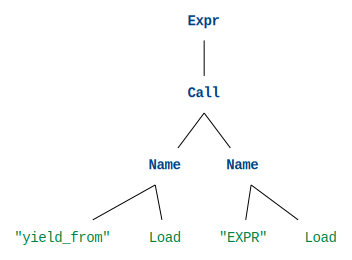

In [25]:
%%showast
yield_from(EXPR)

You will likewise notice that the case of `RESULT = yield_from(EXPR)` is the same with regards to the `Call` node, with only the addition of an `Assign` node (and the `Name` being assigned to):

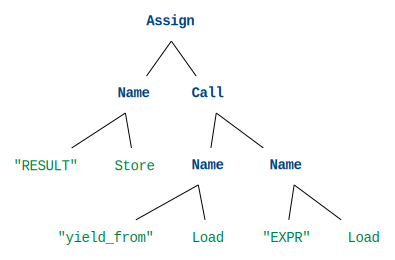

In [26]:
%%showast
RESULT = yield_from(EXPR)

From this, it's relatively easy, given a method of traversing all the nodes of some source code, to match on these patterns (albeit crudely):

In [27]:
code = """
def generator_a():
    yield a
    yield_from(generator_b)
    yield b
    yield_from(generator_c)
    yield z
"""

def is_yield_from(ast_node):
    if not isinstance(ast_node, ast.Call):
        return False
    if not isinstance(ast_node.func, ast.Name):
        return False
    if ast_node.func.id != 'yield_from':
        return False
    return True

parsed_ast = ast.parse(code)
for node in ast.walk(parsed_ast): 
    if is_yield_from(node):
        print('LINE {.lineno}:\n{}\n'.format(node, ast.dump(node)))

LINE 4:
Call(func=Name(id='yield_from', ctx=Load()), args=[Name(id='generator_b', ctx=Load())], keywords=[], starargs=None, kwargs=None)

LINE 6:
Call(func=Name(id='yield_from', ctx=Load()), args=[Name(id='generator_c', ctx=Load())], keywords=[], starargs=None, kwargs=None)



### Defining the replacement code

We now need to adapt the code provided by PEP-380 into an AST representation. 

Before that, however, it's important to note that the code does have one slight incompatibility with Python 2.7: it assumes that any `StopIteration` exception raised has a `.value` attribute. This value is then assigned to `RESULT` within the `RESULT = yield from EXPR` case. Since this will not be true generally in Python 2.7, let's instead make a deliberate `hasattr` check on `.value`, and assign the last yielded value from `EXPR` to `RESULT` in the case where no such attribute exists. All in all, this results in the following, slightly modified code:

In [28]:
def g():
    _i = iter(EXPR)
    _r = None
    _y = None
    try:
        _y = next(_i)
    except StopIteration as _e:
        if hasattr(_e, 'value'):  # hasattr checks are added to ease 2/3 iterator API inconsistency
            _r = _e.value
        else:
            _r = _y
    else:
        while 1:
            try:
                _s = yield _y
            except GeneratorExit as _e:
                try:
                    _m = _i.close
                except AttributeError:
                    pass
                else:
                    _m()
                raise _e
            except BaseException as _e:
                _x = sys.exc_info()
                try:
                    _m = _i.throw
                except AttributeError:
                    raise _e
                else:
                    try:
                        _y = _m(*_x)
                    except StopIteration as _e:
                        if hasattr(_e, 'value'):
                            _r = _e.value
                        else:
                            _r = _y
                        break
            else:
                try:
                    if _s is None:
                        _y = next(_i)
                    else:
                        _y = _i.send(_s)
                except StopIteration as _e:
                    if hasattr(_e, 'value'):
                        _r = _e.value
                    else:
                        _r = _y
                    break
    RESULT = _r

From this, we want to write a function that will take AST nodes corresponding to `EXPR` and `RESULT`, and give us back the corresponding AST for the above with those nodes appropriately inserted. The easiest way to get an AST representation of the above would be to use `ast.dump` on a parsed version, then simply duplicate this in code - but, as you might imagine, this would be extremely verbose. Furthermore, maintaining or updating this representation - suppose we wanted to assign `None` to `RESULT` when the `StopIteration.value` doesn't exist - would be pretty painful.

Ideally, we would instead like to have a minimal representation of the code - essentially, what we've written above - to be used and transformed into an AST. While Python doesn't have code literals in this sense, the library [`asttools`'](https://github.com/hchasestevens/asttools) offers `quoted` and `quoted_template` decorators to do just that. These decorators transform a function body into a list of AST nodes (or, in the case of `quoted_template`, a function that will return AST nodes). As an example:

In [29]:
from asttools import quoted, quoted_template

@quoted
def simple_assignment():
    X = 1 + 1
    
print(simple_assignment)
print(ast.dump(simple_assignment[0]))

Assign(targets=[Name(id='X', ctx=Store())], value=BinOp(left=Num(n=1), op=Add(), right=Num(n=1)))


`simple_assignment` doesn't _perform_ `X = 1 + 1` (and, indeed, [isn't a function at all anymore](the-decorators-they-wont-tell-you-about.ipynb)), but instead is the AST _representation_ of the expression `X = 1 + 1`. Likewise, with `quoted_template`:

In [30]:
@quoted_template
def simple_assignment_template(a):
    X = a + 1

name_y = ast.Name(id='Y')
simple_assignment_ast, = simple_assignment_template(name_y)
print(ast.dump(simple_assignment_ast))

one_plus_one = ast.BinOp(
    left=ast.Num(n=1),
    op=ast.Add(),
    right=ast.Num(n=1)
)
simple_assignment_ast, = simple_assignment_template(one_plus_one)
print(ast.dump(simple_assignment_ast))

Assign(targets=[Name(id='X', ctx=Store())], value=BinOp(left=Name(id='Y', ctx=Load()), op=Add(), right=Num(n=1)))
Assign(targets=[Name(id='X', ctx=Store())], value=BinOp(left=BinOp(left=Num(n=1), op=Add(), right=Num(n=1)), op=Add(), right=Num(n=1)))


As can be seen, we can use this to do exactly what we were hoping - take a natural, terse, syntax-checked snippet of Python code, replace a couple of things, and return the AST. All together, it ends up looking like:

In [31]:
@quoted_template
def yield_from_template(EXPR, RESULT):
    _i = iter(EXPR)
    _r = None
    _y = None
    try:
        _y = next(_i)
    except StopIteration as _e:
        if hasattr(_e, 'value'):
            _r = _e.value
        else:
            _r = _y
    else:
        while 1:
            try:
                _s = yield _y
            except GeneratorExit as _e:
                try:
                    _m = _i.close
                except AttributeError:
                    pass
                else:
                    _m()
                raise _e
            except BaseException as _e:
                _x = sys.exc_info()
                try:
                    _m = _i.throw
                except AttributeError:
                    raise _e
                else:
                    try:
                        _y = _m(*_x)
                    except StopIteration as _e:
                        if hasattr(_e, 'value'):
                            _r = _e.value
                        else:
                            _r = _y
                        break
            else:
                try:
                    if _s is None:
                        _y = next(_i)
                    else:
                        _y = _i.send(_s)
                except StopIteration as _e:
                    if hasattr(_e, 'value'):
                        _r = _e.value
                    else:
                        _r = _y
                    break
    RESULT = _r

yield_from_template(
    ast.parse("(x for x in y)").body[0],
    ast.Name(id='_')
)

### Writing the substitution procedure

Now, all we have left is writing something to:
- Grab the code of the target generator, and parse it into an AST
- Perform the AST node replacement, using the pattern and template we described above
- Re-compile the resultant AST and replace the original generator

Thankfully, Python gives us a lot of the tools we need for this out-of-the-box. In terms of replacing a generator at definition-time, decorators provide a very nice, clean syntax for this. Grabbing the source AST can be done by using `get_ast` from [`asttools`](https://github.com/hchasestevens/asttools) - but, under the hood, all this is really doing is using [`inspect.getsource`](https://docs.python.org/2/library/inspect.html#inspect.getsource) and `ast.parse`. Transforming the AST can be done by subclassing the aptly-named [`ast.NodeTransformer`](https://docs.python.org/2/library/ast.html#ast.NodeTransformer). Finally, ASTs can be compiled into code objects via the builtins `compile` and `exec`.

Putting those all together, we get the following:

In [32]:
import sys
import asttools

def yield_from(expression):
    pass  # Calls to this function are replaced with the yield_from_template via the below.

class YieldFromExprReplacer(ast.NodeTransformer):
    """
    Replace expressions of the form `yield_from({EXPR})` with the semantic
    equivalent of `yield from {EXPR}` specified in PEP-380.
    """
    def visit_Expr(self, node):
        if not is_yield_from(node.value):
            return self.generic_visit(node)

        replacement_nodes = yield_from_template(
            node.value.args[0],  # The expression being passed as the first (only) argument to yield_from.
            ast.Name(id='_result')  # A throwaway name
        )

        # In order to replace the assignment with multiple nodes, we wrap them in an "if 1:" block.
        return ast.If(
            test=ast.Num(n=1),
            body=replacement_nodes,
            orelse=[]
        )

def rewrite_yield_from(fn):
    fn_ast = asttools.get_ast(fn)

    # Replace yield_from calls in function AST
    rewritten_ast = YieldFromExprReplacer().visit(fn_ast)
    ast.fix_missing_locations(rewritten_ast)

    # Recompile rewritten AST into function object and return
    env = sys._getframe(1).f_locals.copy()
    env[rewrite_yield_from.__name__] = lambda x: x
    rewritten_fn = compile(
        ast.Module(body=[rewritten_ast]),
        getattr(fn.__module__, '__file__', '<no_module>'),
        'exec'
    )
    exec(rewritten_fn, fn.__globals__, env)
    return env[fn.__name__]

With any luck, this should now work for both the simple and complex cases:

In [33]:
def inner_g():
    received = yield "I am inner_g"
    yield "I received {!r}".format(received)
    
@rewrite_yield_from
def outer_g():
    yield "I am outer_g"
    yield "I am about to yield from inner_g"
    yield_from(inner_g())
    yield "~fin~"
    
[s for s in outer_g()]

['I am outer_g',
 'I am about to yield from inner_g',
 'I am inner_g',
 'I received None',
 '~fin~']

In [34]:
to_send = [None, None, None, 'Hi, inner_g!', None]
gen = outer_g()
for value in to_send:
    print(gen.send(value))

I am outer_g
I am about to yield from inner_g
I am inner_g
I received 'Hi, inner_g!'
~fin~


_Et voilà_, the `yield from` is backported!

## Concluding remarks

Naturally, for the convenience of those stuck maintaining Python 2.7 codebases, I have made this [`yield from` backport](https://github.com/hchasestevens/yield-from) available as a PyPI package, installable via:
```bash
pip install yield-from
```
This PyPI package also handles the case of `RESULT = yield_from(EXPR)`, which we did not cover in the above code.

However, aside from the specific case of backporting `yield from`, it is hopefully clear that the AST manipulation techniques presented in this piece are applicable to a far broader range of situations - for instance, [pattern matching](https://github.com/Suor/patterns), [performance optimization](https://github.com/vstinner/fatoptimizer), [building DSLs](https://github.com/hchasestevens/xpyth), [generating javascript](http://hackflow.com/blog/2015/04/12/metaprogramming-beyond-decency-part-2/), [creating more readable tests](https://chezsoi.org/lucas/blog/pytest-ast-modification-getting-the-tests-final-code.html), and, generally, anywhere you wish Python could be doing a find-replace on your codebase for you. 

This is not to say that AST manipulation isn't without its drawbacks, some quite serious. Perhaps most perniciously, your source code becomes a lie: what you see is not what gets run, and oftentimes stack traces no longer line up nicely with the code you've manipulated. Furthermore, understanding the manipulation requires a lot of background knowledge (you've just read an entire article on it), placing an unavoidable and onerous expectation on anyone looking to work with or maintain the codebase - a problem, especially, for junior developers. 

As with any powerful tool, determining the circumstances under which the benefits AST manipulation can bring outweigh these drawbacks is best left to the discretion of you, the reader.

## About the author
* Name: [H. Chase Stevens](http://www.chasestevens.com)
* Github: [hchasestevens](https://github.com/hchasestevens)
* Twitter: [@hchasestevens](https://twitter.com/hchasestevens)
